# Discriminability of States and Traits

In [4]:
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import pickle

%matplotlib inline

import seaborn as sns

sns.set(color_codes=True, style="white", context="talk", font_scale=1)
PALETTE = sns.color_palette("Set1")

from sklearn.metrics import pairwise_distances
from sklearn.manifold import MDS
from hyppo.independence import Dcorr
from scipy.stats import multiscale_graphcorr
from hyppo.ksample._utils import k_sample_transform
from graspy.plot import heatmap, pairplot

import sys

sys.path.append("../")
from src.tools.utils import get_files, get_latents

%load_ext autoreload
%autoreload 2
%load_ext nb_black

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<IPython.core.display.Javascript object>

In [2]:
## Define paths
base_dir = Path("/mnt/ssd3/ronan/data/gcca_05-26-10:39_min_rank-ZG3/")
external_dir = Path('../data/external')
groups, labels = get_latents(base_dir, flag='_gcca')
print(labels)

[['e', 'restingstate'], ['e', 'openmonitoring'], ['e', 'compassion'], ['n', 'restingstate'], ['n', 'openmonitoring'], ['n', 'compassion']]


In [71]:
def disc_stat(dist_mat, labels):
    dist_mat = np.asarray(dist_mat)
    N = dist_mat.shape[0]
    stats = []

    ## For each label
    for label in np.unique(labels):
        idxs_in = np.where(labels == label)[0]
        idxs_out = np.where(labels != label)[0]
        stat = []
        for i in idxs_in:  ## For each row in the in idxs
            stat.append(
                [
                    1
                    - (
                        np.sum(dist_mat[i, j] < dist_mat[i, idxs_out])
                        + 0.5 * np.sum(dist_mat[i, j] == dist_mat[i, idxs_out])
                    )
                    / len(idxs_out)
                    for j in idxs_in
                    if i != j
                ]
            )
        ## Average percent of the time in group is larger than out group
        stats.append(np.mean(stat))

    # Equally weights each unique label
    return np.mean(stats)


def disc_pval(dist_mat, labels, n_permutations=100):
    y = labels.copy()
    obs_stat = disc_stat(dist_mat, y)
    pval = 1 / (n_permutations + 1)

    for _ in range(n_permutations):
        np.random.shuffle(y)
        null_stat = disc_stat(dist_mat, y)
        if null_stat <= obs_stat:
            pval += 1 / (n_permutations + 1)

    return obs_stat, pval

<IPython.core.display.Javascript object>

## Experts vs. Novices

In [88]:
ways = [[0], [0], [0], [1], [1], [1]]
X, Y = k_sample_transform([np.asarray(g) for g in groups], ways=ways)
X = X[:, :, :3].reshape(X.shape[0], -1)

<IPython.core.display.Javascript object>

In [89]:
X_dists = pairwise_distances(X, metric="euclidean")
Y_dists = pairwise_distances(Y, metric="sqeuclidean") / 2

<IPython.core.display.Javascript object>

In [92]:
en_disc, en_pval = disc_pval(X_dists, Y[:, 0], n_permutations=1000)

<IPython.core.display.Javascript object>

In [91]:
en_disc

0.49017812963879265

<IPython.core.display.Javascript object>

In [93]:
en_pval

0.000999000999000999

<IPython.core.display.Javascript object>

## Within Expert states

In [94]:
ways = [[0], [1], [2]]
X, Y = k_sample_transform([np.asarray(groups[i]) for i in [0, 1, 2]], ways=ways)
X = X[:, :, :3].reshape(X.shape[0], -1)

<IPython.core.display.Javascript object>

In [95]:
X_dists = pairwise_distances(X, metric="euclidean")
Y_dists = pairwise_distances(Y, metric="sqeuclidean") / 2

<IPython.core.display.Javascript object>

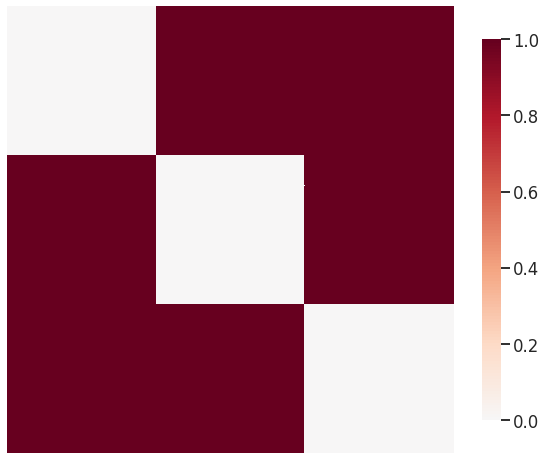

<IPython.core.display.Javascript object>

In [96]:
heatmap(Y_dists)

In [97]:
e_states_stat, e_stats_pval = disc_pval(X_dists, Y[:, 0], n_permutations=1000)

<IPython.core.display.Javascript object>

In [98]:
print(f"Stat {e_states_stat}")
print(f"pval {e_states_pval}")

Stat 0.5012225867880163
pval 0.6237623762376241


<IPython.core.display.Javascript object>

## Experts med vs. resting

In [99]:
ways = [[0], [1], [1]]
X, Y = k_sample_transform([np.asarray(groups[i]) for i in [0, 1, 2]], ways=ways)
X = X[:, :, :3].reshape(X.shape[0], -1)

<IPython.core.display.Javascript object>

In [100]:
X_dists = pairwise_distances(X, metric="euclidean")
Y_dists = pairwise_distances(Y, metric="sqeuclidean") / 2

<IPython.core.display.Javascript object>

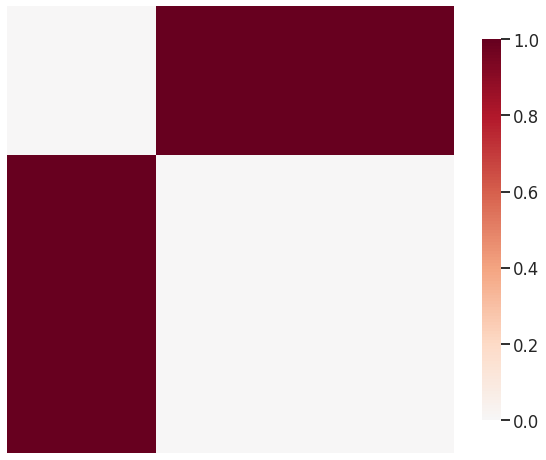

<IPython.core.display.Javascript object>

In [101]:
heatmap(Y_dists)

In [102]:
e_rmed_stat, e_rmed_pval = disc_pval(X_dists, Y[:, 0], n_permutations=1000)

<IPython.core.display.Javascript object>

In [103]:
print(f"Stat {e_rmed_stat}")
print(f"pval {e_rmed_pval}")

Stat 0.5012225867880163
pval 0.5524475524475551


<IPython.core.display.Javascript object>

## Experts med vs novices med

In [104]:
ways = [[0], [0], [1], [1]]
X, Y = k_sample_transform([np.asarray(groups[i]) for i in [1, 2, 4, 5]], ways=ways)
X = X[:, :, :3].reshape(X.shape[0], -1)

X_dists = pairwise_distances(X, metric="euclidean")
Y_dists = pairwise_distances(Y, metric="sqeuclidean") / 2

en_med_stat, en_med_pval = disc_pval(X_dists, Y[:, 0], n_permutations=1000)
print(f"Stat {en_med_stat}")
print(f"pval {en_med_pval}")

Stat 0.488032200350354
pval 0.001998001998001998


<IPython.core.display.Javascript object>

## Experts med vs novices rest

In [105]:
ways = [[0], [0], [1]]
X, Y = k_sample_transform([np.asarray(groups[i]) for i in [1, 2, 3]], ways=ways)
X = X[:, :, :3].reshape(X.shape[0], -1)

X_dists = pairwise_distances(X, metric="euclidean")
Y_dists = pairwise_distances(Y, metric="sqeuclidean") / 2

en_medr_stat, en_medr_pval = disc_pval(X_dists, Y[:, 0], n_permutations=1000)
print(f"Stat {en_medr_stat}")
print(f"pval {en_medr_pval}")

Stat 0.4879533217713652
pval 0.011988011988011991


<IPython.core.display.Javascript object>